In [1]:
# --- jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.16.1
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

In [1]:
from jupyter_client import find_connection_file

connection_file = find_connection_file()
print(connection_file)

/home/yonatan/.local/share/jupyter/runtime/kernel-3e8447ab-00f4-4986-81a5-1d0090baae61.json


In [3]:
# Plotting related
import os
import sys

sys.tracebacklimit = 0

import seaborn as sns

# sns.set_palette(["#3498db", "orange"])

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio


# Scikit-learn related imports
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", None)
pd.options.mode.copy_on_write = True

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, ttest_ind
from sklearn.linear_model import LogisticRegression

# Jupyter-related
from IPython.display import Markdown as md


# Constants for this project
import constants
from constants import *

In [4]:
# Change the current working directory
os.chdir("/home/yonatan/Documents/projects/vaccines/code")

# maybe make plotly work
pio.renderers.default = "notebook"

In [5]:
def get_data_dir():
    # Define the starting directory
    current_dir = os.getcwd()

    # Traverse up the directory tree until we find a directory named "data"
    while current_dir != "/":
        if "data" in os.listdir(current_dir):
            data_dir = os.path.join(current_dir, "data")
            return data_dir
        current_dir = os.path.dirname(current_dir)
    else:
        print("Directory 'data' not found in the parent directories.")
        raise ()

In [6]:
# Read in Data and drop missing values
data_dir = get_data_dir()
df = pd.read_csv(os.path.join(data_dir, "../data/all_vaccines.csv"))
df.dropna(inplace=True, subset=[immage_col, dataset_col, day_col, response_col])

datasets = df
dataset_names = df.Dataset.unique()

In [7]:
# print out all days per dataset
# tmp_df = df[[dataset_col, day_col]]
# tmp_df['Day'] = pd.Categorical(tmp_df['Day'])

# # Group by Dataset and aggregate unique Days preserving order
# result = tmp_df.groupby('Dataset')['Day'].agg(lambda x: list(x.unique())).reset_index()

# for idx, row in result.iterrows():
#     print(row.Dataset, row.Day)

In [8]:
# #### Distribution of studies' N values
N_vals = datasets[[dataset_col, uid_col]].groupby(dataset_col, as_index=False)[uid_col].nunique()
N_vals = N_vals.rename(columns={uid_col: "N"})
# sns.histplot(N_vals.N)
# plt.title("N values across studies")
# plt.show()

In [9]:
# Narrow N_v to large datasets only
bNarrow = False
large_N = N_vals.loc[N_vals["N"] > 70]
if bNarrow:
    print("Narrowing to large datasets only")
    datasets = df.loc[df["Dataset"].isin(large_N["Dataset"])]

dataset_names = datasets["Dataset"].unique()

In [10]:
# These parameters are overridden by papermill
strain_index = 2
dataset_name = "GSE48023.SDY1276"
day = "nAb.D14"
day0 = "HAI.D0"
dayMFC = "HAI.MFC"

bAdjustMFC = False
bInfluenza = False
bDiscardSeroprotected = True
bOlderOnly = False

In [11]:
if bInfluenza:
    tmp_df = pd.DataFrame(influenza_dicts)
    datasets = df.loc[df["Dataset"].isin(tmp_df["Dataset"])]
    dataset_names = datasets["Dataset"].unique()
    tmp_df['Days'] = tmp_df['Days'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)  # Convert list to string for display
    # print(tmp_df)
    print("Working with Influenza datasets only")

In [12]:
# Narrow to a specific datset and strain
name_mask = datasets[dataset_col] == dataset_name
# Somtimes there are multiple strains - so multiple rows per day
strains = datasets.loc[name_mask][strain_col].unique()
strain = strains[strain_index]
strain_mask = datasets[strain_col] == strain

dataset = datasets.loc[(name_mask) & (strain_mask)].reset_index(drop=True)

In [13]:
# Pivot the dataset such that different days' samples appear in their own columns, witn NaN where there are missing samples
t = dataset[[dataset_col, uid_col, age_col, immage_col, "geo_accession", day_col, response_col, strain_col]]
pivot_t = t.pivot_table(index=[uid_col, strain_col], columns=day_col, values=response_col, aggfunc='first')
age_t = dataset[['uid', 'Age']].drop_duplicates()

# Average IMMAGE values across geo_accessions (if they exist) and merge
immage_t = t.groupby('uid')[immage_col].mean()
tmp_t = age_t.merge(immage_t, on='uid', how='left').drop_duplicates()
pivot_t = tmp_t.merge(pivot_t, on='uid', how='left')

# Reset index to make uid a column again
pivot_t.reset_index(inplace=True, drop=True)

# Remove the name of the columns and index name
pivot_t.columns.name = None
pivot_t.index.name = None

# Currently only used by AdjustMFC branch. TODO: convert the "regular" to use it too
pivot_dataset = pivot_t

In [14]:
# Sometimes there are multiple geo_accession numbers, like in GSE48018.SDY1276.
# Average the IMMAGE, since all else is the same
def remove_duplicate_accessions(dataset, immage_col, uid_col):
    first_uid = dataset.iloc[0][uid_col]
    accessions = dataset[dataset[uid_col] == first_uid]["geo_accession"].unique()
    if len(accessions) > 1:
        # print(f"Multiple accession detected, Collapsing by averaging on IMMAGE value")
        dataset = dataset.groupby(uid_col, as_index=False).agg({immage_col: "mean", **{col: "first" for col in dataset.columns if col not in [uid_col, immage_col]},})

    accessions = dataset[dataset[uid_col] == first_uid]["geo_accession"].unique()
    assert len(accessions) == 1

    return dataset

In [15]:
from sklearn.cluster import KMeans
# Use adjusted MFC (HAI) as per John Tsang
# Calculate AdjMFC from scratch, but not maximum across strains, rather look at each strain separately.

if bAdjustMFC:
    print("Preprocessing dataset, computing adjusted FC")
    metadata = pd.DataFrame(dataset_day_dicts_for_adjFC)
    days = metadata[metadata[dataset_col] == dataset_name]["Days"].iloc[0]
    sampleDay = [x for x in days if "D0" not in x][0]
    day0 = [x for x in days if "D0" in x][0]
    cluster_col = day0

    # Pivot the table to have a column per day
    dataset = pivot_dataset[[uid_col, immage_col, age_col, day0, sampleDay]]
    dataset = dataset.loc[(~pivot_t[day0].isna()) & (~pivot_t[sampleDay].isna())] ;
    dataset["FC"] = dataset[sampleDay]/dataset[day0]

    # Remove outliers
    mean = dataset[day0].mean()
    std = dataset[day0].std()
    threshold = 3 * std
    dataset = dataset[(dataset[day0] >= mean - threshold) & (dataset[day0] <= mean + threshold)]

    # Bin subjects into 2-3 bins using k-means clustering
    kmeans = KMeans(n_clusters=3, random_state=0)
    dataset['Cluster'] = kmeans.fit_predict(dataset[[cluster_col]])

    def normalize(x):
        return (x - x.median()) / x.std()

    # Normalize the FC within each bin to obtain the adjFC
    dataset['adjFC'] = dataset.groupby('Cluster')["FC"].transform(normalize)

    # Take relevant columns only
    data = dataset[[immage_col, 'adjFC', age_col, cluster_col, "Cluster"]].rename(columns={'adjFC': response_col}).dropna()
    # data.groupby("Cluster").count()

In [16]:
# Visualize clusters
if bAdjustMFC:
    custom_palette = {0: "red", 1: "blue", 2: "green"}
    sorted_data = data.sort_values(cluster_col, ignore_index=True).reset_index()
    sns.scatterplot(data=sorted_data, x="index", y=cluster_col, hue="Cluster", palette=custom_palette)
    # plt.axhline(y=threshold, color="black", linestyle="--")
    plt.title(f"{cluster_col} clustered")

In [17]:
# Discard seroprotected subjects based on HAI > 40 threshold)
if bDiscardSeroprotected:
    HAI_threshold = 40
    day0_mask = dataset[day_col] == day0
    threshold_mask = dataset[response_col ]> HAI_threshold

    # Get a list of all protected patients
    serprotected_subjects = dataset.loc[(day0_mask) & (threshold_mask)][uid_col].unique()
    # keep only patients not in the serprotected_subjects list
    dataset = dataset.loc[~dataset[uid_col].isin(serprotected_subjects)]
    subjects_left = dataset[uid_col].unique()
    print(f"Discarding {len(serprotected_subjects)} seroprotected subjects")
    print(f"Subjects left: N={len(subjects_left)}")

Discarding 0 seroprotected subjects
Subjects left: N=110


In [18]:
if bAdjustMFC == False:
    # If not computing adjFC, take a specific strain from the given post-vaccine day & assay
    day_mask = dataset[day_col] == day
    dataset = dataset.loc[(day_mask)].reset_index(drop=True)

    dataset = remove_duplicate_accessions(dataset, immage_col, uid_col)

    # Take relevant columns only
    data = dataset[[immage_col, response_col, age_col]]

In [19]:
# Keep older subjects only, since that's what's actually more interesting, and may show IMMAGE's advantage
age_threshlod = 60
if bOlderOnly == True:
    young_subjects = data.loc[data[age_col] < age_threshlod]
    data = data.loc[data[age_col] >= age_threshlod]
    if len(data) == 0:
        raise(Exception("No subjects over the age of {age_threshlod}. Exiting."))
    print(f"Discarding {len(young_subjects)} seroprotected subjects")
    print(f"Subjects left: N={len(data)}")

In [20]:
#### Dataset & Strain info

age_restrict_str = f", Subjects over the age of {age_threshlod}" if bOlderOnly else ""
day_str = "Adjusted MFC" if bAdjustMFC else f"day: {day}"

md(f"""### Analysis for dataset: {dataset_name}, strain: {strain}, {day_str}{age_restrict_str}""")

### Analysis for dataset: GSE48023.SDY1276, strain: A/Brisbane/10/2007, day: nAb.D14

In [21]:
md(
    f"""Working with dataset: {dataset_name}, strain: {strain}, {day_str}\n
Total subjects in study: N = {data.shape[0]}\n
Other strains in this study: {strains}"""
)

Working with dataset: GSE48023.SDY1276, strain: A/Brisbane/10/2007, day: nAb.D14

Total subjects in study: N = 110

Other strains in this study: ['A/Brisbane/59/2007' 'B/Florida/4/2006' 'A/Brisbane/10/2007']

In [22]:
data.reset_index(inplace=True, drop=True)

# Get a boolean map of sub and super threshold values
low_response_thr = data[[response_col]].quantile(q=0.3).item()

# Generate labels
# Note that we define y=1 for all responses <= 30th percentile (and not <)
# Also note that we defined y=1 as *non* responders, since later on that's what we'll care about detecting

data["y"] = data[response_col].apply(lambda x: 1 if x <= low_response_thr else 0)

# Add a text label for plot legends
data["Label text"] = data["y"].apply(lambda x: "Responders" if x == 0 else "Non-Responders")

#### Dynamic ranges of IMMAGE, response, and age values

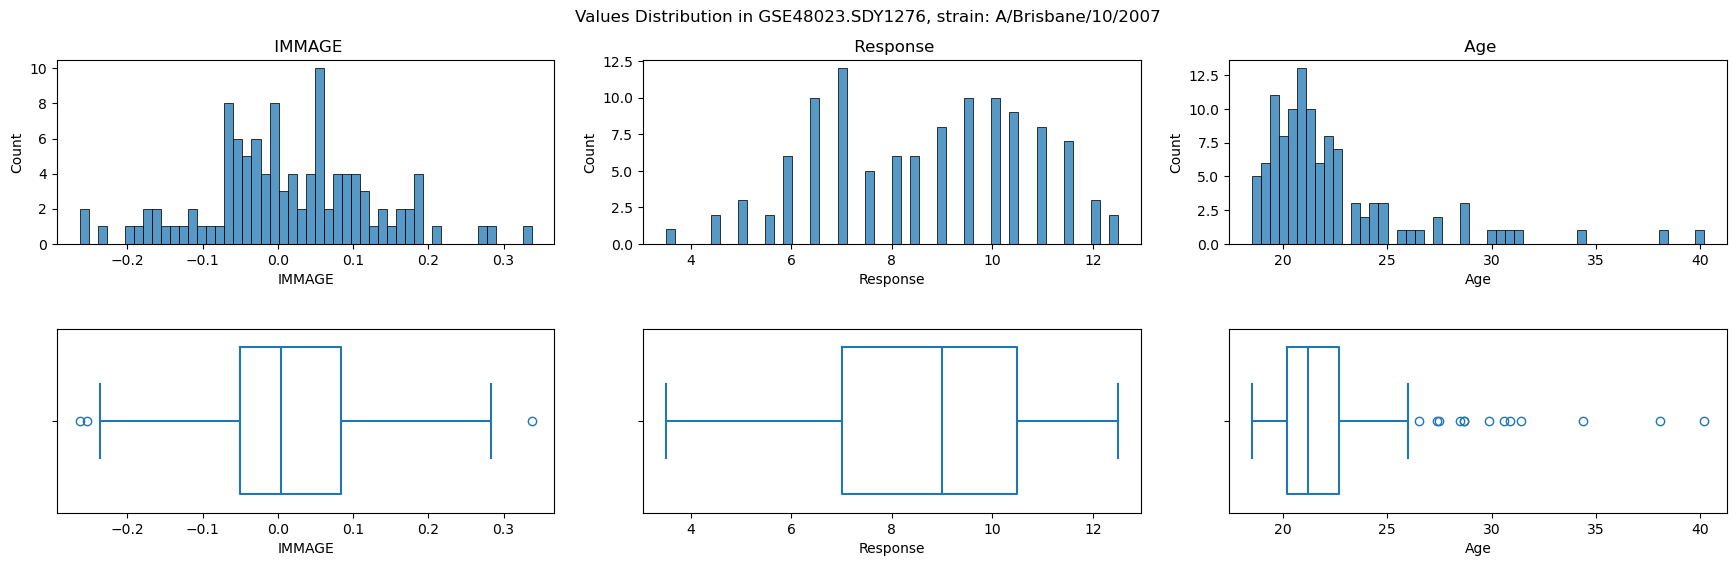

In [23]:
# Plot IMMAGE, response, and age values to look at the dynamic range
from scipy.stats import probplot

fig, axs = plt.subplots(2, 3, figsize=(18, 6))  # Create a figure with two subplots side by side

sns.histplot(data=data, x=immage_col, bins=50, ax=axs[0, 0])
sns.boxplot(data=data, x=immage_col, ax=axs[1, 0], fill=False)
# axs[0].set_title('Box Plot')
axs[0, 0].set_title(f" {immage_col}")

sns.histplot(data=data, x=response_col, bins=50, ax=axs[0, 1])
sns.boxplot(data=data, x=response_col, ax=axs[1, 1], fill=False)
# axs[1].set_title('Box Plot')
axs[0, 1].set_title(f" {response_col}")

sns.histplot(data=data, x=age_col, bins=50, ax=axs[0, 2])
sns.boxplot(data=data, x=age_col, ax=axs[1, 2], fill=False)
# axs[1].set_title('Box Plot')
axs[0, 2].set_title(f" {age_col}")

plt.tight_layout(pad=3.0)  # Adjust the layout so everything fits without overlap
fig.suptitle(f"Values Distribution in {dataset_name}, strain: {strain}")

plt.show()

In [24]:
# Classifying with logistic regression - fit on the entire dataset
from math import log


def get_threshold_from_probability(prob, intercept, slope):
    return -1 * (log(1 / prob - 1) + intercept) / slope


log_regress_immage = LogisticRegression()
log_regress_age = LogisticRegression()
log_regress_combined = LogisticRegression()

# Train a classifier based on immage and on age for comparison
log_regress_immage.fit(data[[immage_col]], data["y"])
log_regress_age.fit(data[[age_col]], data["y"])
log_regress_combined.fit(data[[immage_col, age_col]], data["y"])

non_responder_col = "p_non_responder"
non_responder_col_age = "p_non_responder_age"
non_responder_col_combined = "p_non_responder_combined"

# data.reset_index(in_place=True, drop=True)

proba = pd.DataFrame(log_regress_immage.predict_proba(data[[immage_col]]))
data[non_responder_col] = proba[1]
proba = pd.DataFrame(log_regress_age.predict_proba(data[[age_col]]))
data[non_responder_col_age] = proba[1]
proba = pd.DataFrame(log_regress_combined.predict_proba(data[[immage_col, age_col]]))
data[non_responder_col_combined] = proba[1]

In [25]:
# Define auxilary functions
from sklearn.metrics import auc, roc_auc_score, precision_recall_curve
from math import log


def calc_and_plot_prob_threshold(data, classifier, precision, recall, thresholds, prob_column, features=""):
    AUC = auc(recall, precision)
    intercept = classifier.intercept_[0]
    slope = classifier.coef_[0][0]

    naive_classification_precision = data["y"].mean()

    # Identifying the optimal threshold (maximal F1 score)
    beta = 0.7
    F_scores = (1+pow(beta, 2))*(precision * recall)/(pow(beta, 2)*precision + recall)
    optimal_idx = np.nanargmax(F_scores)
    prob_threshold = thresholds[optimal_idx]
    score = F_scores[optimal_idx]

    # Calculate the cutoff value
    feature_threshold = get_threshold_from_probability(
        prob_threshold, intercept=intercept, slope=slope
    )

    fig, axs = plt.subplots(
        1, 2, figsize=(16, 6)
    )  # Creates a figure with two side-by-side subplots

    # Plot PRC on the first subplot
    axs[0].plot(recall, precision, label=f"Precision-Recall curve (area = {AUC : 0.2f})", color="#9b59b6")
    axs[0].axhline(y=naive_classification_precision, color="black", linestyle="--")
    axs[0].plot(recall[optimal_idx], precision[optimal_idx], marker="o", markersize=5, color="red")
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title("Precision-Recall curve")
    axs[0].legend(loc="lower right")

    custom_palette = {"Non-Responders": "orange", "Responders": "#3498db"}

    if len(features) == 1:
        col_name = features[0]
        # Plot sorted feature values vs Index on the second subplot
        sorted_data = data.sort_values(col_name, ignore_index=True).reset_index()
        sns.scatterplot(
            ax=axs[1], data=sorted_data, x="index", y=col_name, hue="Label text", palette=custom_palette
        )
        axs[1].axhline(y=feature_threshold, color="black", linestyle="--")
        axs[1].set_title(f"Sorted {col_name} vs Index")


    else: # len(features) > 1
        predicted_true = data.loc[data[prob_column] >= prob_threshold]

        sns.scatterplot(
            ax=axs[1], data=predicted_true, x=features[0], y=features[1], marker="x", s=100, color="red"
        )
        
        sns.scatterplot(
            ax=axs[1], data=data, x=features[0], y=features[1], hue="Label text", palette=custom_palette
        )
        axs[1].set_title(f"IMMAGE and Age, colour=response/non-response")


    fig.suptitle(f"Probability-based threshold with PRC\n({dataset_name}, {strain})")
    plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
    plt.show()

    return (score, prob_threshold, feature_threshold, AUC)


def get_classifier_stats_prob(data, prob_column, prob_threshold):
    # Global measures (entire dataset)
    optimal_pred = data[prob_column].apply(lambda x: 1 if x >= prob_threshold else 0)
    test_accuracy = accuracy_score(data["y"], optimal_pred)
    # Performance above the prob_threshold
    y_over_thr = data.loc[data[prob_column] >= prob_threshold, ["y"]]
    non_response_rate_over_thr = y_over_thr.mean().y
    y_under_thr = data.loc[data[prob_column] < prob_threshold, ["y"]]
    non_response_rate_under_thr = y_under_thr.mean().y
    return non_response_rate_over_thr, non_response_rate_under_thr

#### Thresholding based on logistic regression probabilties

#### IMMAGE-based classification

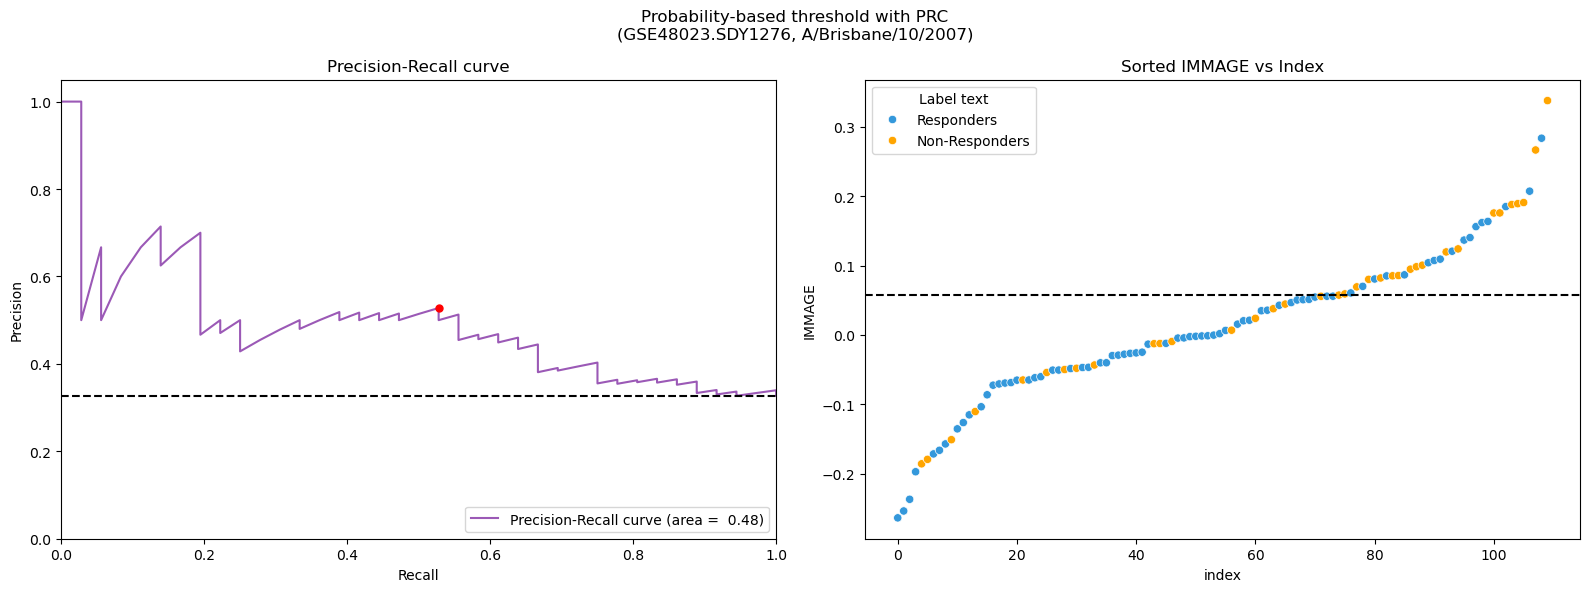

In [26]:
# Run for immage and age to compare
# IMMAGE
precision, recall, thresholds = precision_recall_curve(data["y"], data[non_responder_col])
immage_score, prob_threshold, immage_threshold, immage_auc = calc_and_plot_prob_threshold(
    data, log_regress_immage, precision, recall, thresholds, non_responder_col, features=[immage_col]
)
non_response_rate_over_thr, non_response_rate_under_thr = get_classifier_stats_prob(
    data, non_responder_col, prob_threshold
)

#### Age-based classification

/tmp/ipykernel_130975/3940073930.py:15: RuntimeWarning:

invalid value encountered in divide



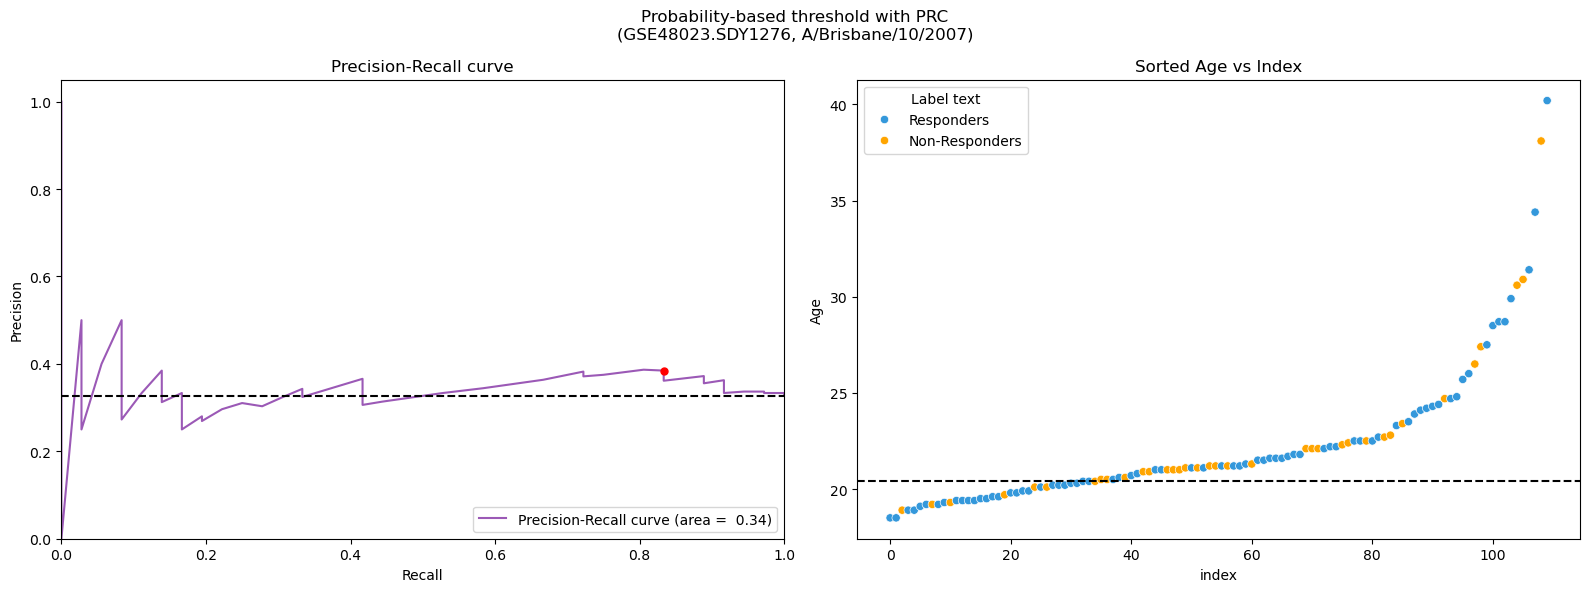

In [27]:
# Age
precision, recall, thresholds = precision_recall_curve(data["y"], data[non_responder_col_age])
age_score, prob_threshold_age, age_threshold, age_auc = calc_and_plot_prob_threshold(
    data, log_regress_age, precision, recall, thresholds, non_responder_col_age, features=[age_col]
)
age_non_response_rate_over_thr, age_non_response_rate_under_thr = get_classifier_stats_prob(
    data, non_responder_col_age, prob_threshold_age
)

#### Age & IMMAGE combined

/tmp/ipykernel_130975/3940073930.py:15: RuntimeWarning:

invalid value encountered in divide



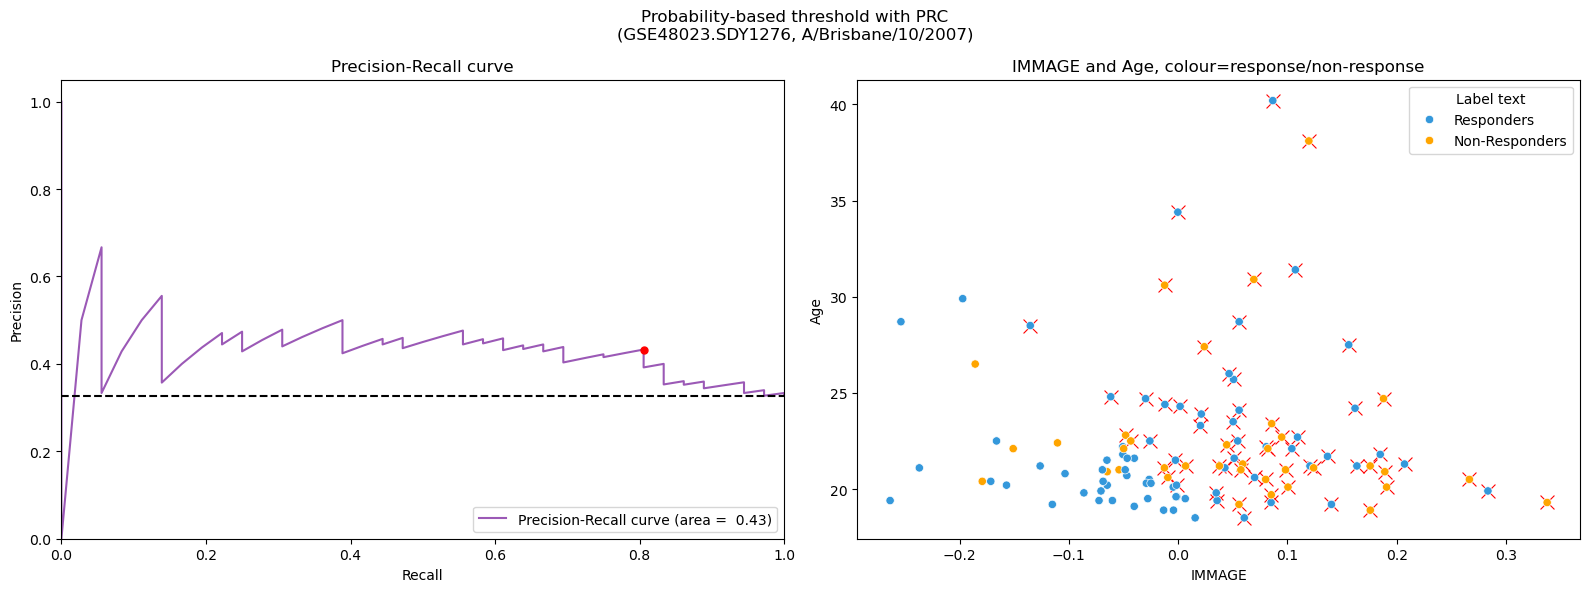

In [28]:
# Combined
precision, recall, thresholds = precision_recall_curve(data["y"], data[non_responder_col_combined])
combined_score, prob_threshold_combined, _, combined_auc = calc_and_plot_prob_threshold(
    data, log_regress_combined, precision, recall, thresholds, non_responder_col_combined, features=[immage_col, age_col]
)
combined_non_response_rate_over_thr, combined_non_response_rate_under_thr = (
    get_classifier_stats_prob(data, non_responder_col_combined, prob_threshold_combined)
)

#### Comparison of using the different features

In [29]:
summary = {
    "Variable": ["IMMAGE", "Age", "Multivariate"],
    # "Optimal threshold": [immage_threshold, age_threshold, prob_threshold_combined],
    "Optimal F-beta score": [immage_score, age_score, combined_score],
    # "PRC AUC": [immage_auc, age_auc, combined_auc],
    # NR = Non-response
    "NR rate over threshold": [
        non_response_rate_over_thr,
        age_non_response_rate_over_thr,
        combined_non_response_rate_over_thr,
    ],
    "NR rate under threshold": [
        non_response_rate_under_thr,
        age_non_response_rate_under_thr,
        combined_non_response_rate_under_thr,
    ],
    
}

df = pd.DataFrame(summary)
df["Composite"] = df[["Optimal F-beta score", "NR rate over threshold"]].mean(axis=1)
print(df.to_string(index=False))

    Variable  Optimal F-beta score  NR rate over threshold  NR rate under threshold  Composite
      IMMAGE                  0.53                    0.53                     0.23       0.53
         Age                  0.47                    0.38                     0.19       0.43
Multivariate                  0.51                    0.43                     0.16       0.47


In [30]:
summary_dict = {
("F score", "IMMAGE"): [immage_score],
("F score", "Age"): [age_score],
("F score", "Multivariate"): [combined_score],
("NR rate over threshold", "IMMAGE"): [non_response_rate_over_thr],
("NR rate over threshold", "Age"): [age_non_response_rate_over_thr],
("NR rate over threshold", "Multivariate"): [combined_non_response_rate_over_thr],
("NR rate under threshold", "IMMAGE"): [non_response_rate_under_thr],
("NR rate under threshold", "Age"): [age_non_response_rate_under_thr],
("NR rate under threshold", "Multivariate"): [combined_non_response_rate_under_thr],
}

# Create a MultiIndex
multi_index = pd.MultiIndex.from_product([["F score", "NR rate over threshold", "NR rate under threshold"], ["IMMAGE", "Age", "Multivariate"]])

# Create the DataFrame
summary = pd.DataFrame(summary_dict, columns=multi_index)
summary["Composite", "IMMAGE"] = summary[[("F score", "IMMAGE"), ("NR rate over threshold", "IMMAGE")]].mean(axis=1)
summary["Composite", "Age"] = summary[[("F score", "Age"), ("NR rate over threshold", "Age")]].mean(axis=1)
summary["Composite", "Multivariate"] = summary[[("F score", "Multivariate"), ("NR rate over threshold", "Multivariate")]].mean(axis=1)
print(summary)

  F score                   NR rate over threshold                    \
   IMMAGE  Age Multivariate                 IMMAGE  Age Multivariate   
0    0.53 0.47         0.51                   0.53 0.38         0.43   

  NR rate under threshold                   Composite                    
                   IMMAGE  Age Multivariate    IMMAGE  Age Multivariate  
0                    0.23 0.19         0.16      0.53 0.43         0.47  
